<a href="https://colab.research.google.com/github/Laurahg22/Trabajo-analitica-RH/blob/main/d_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importe de librerías

In [1]:
## Conectar el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#### Cargar paquetes siempre al inicio
import pandas as pd ### para manejo de datos
import sqlite3 as sql #### para bases de datos sql
import sys ## saber ruta de la que carga paquetes
import numpy as np
import matplotlib.pyplot as plt ### gráficos

from sklearn import linear_model, tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, get_scorer_names, accuracy_score,confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler ## escalar variables

import joblib  ### para guardar modelos
import openpyxl

sys.path ###Ruta directorio qué tiene paquetes
sys.path.append('/content/drive/MyDrive/trabajo/Trabajo-analitica-RH') ## este comanda agrega una ruta

import a_funciones as funciones  ###archivo de funciones propias

In [3]:
# Leer datos de 015
df2015 = pd.read_csv('/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/data/df2015.csv')
df2015

,Age,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51,6,2,0,1,131160,1.0,11,0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,31,10,1,0,1,41890,0.0,23,1,6.0,...,0,0,0,0,1,0,0,0,0,1
2,32,17,4,1,4,193280,1.0,15,3,5.0,...,0,0,0,0,0,1,0,0,1,0
3,38,2,5,1,3,83210,3.0,11,3,13.0,...,0,0,0,0,0,0,0,0,1,0
4,32,10,1,1,1,23420,4.0,12,2,9.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,5,4,0,1,60290,3.0,17,1,10.0,...,0,0,0,0,1,0,0,0,0,1
4406,29,2,4,1,1,26790,2.0,15,0,10.0,...,1,0,0,0,0,0,0,1,0,0
4407,25,25,2,1,2,37020,0.0,20,0,5.0,...,0,0,0,0,0,1,0,0,1,0
4408,42,18,2,1,1,23980,0.0,14,1,10.0,...,1,0,0,0,0,0,0,1,0,0




## Escalado y/o estandarización de los datos

In [4]:
######## con base en los modelos candidatos se realizará una selección de variables ########
y = df2015['Attrition']
X1 = df2015.loc[:, ~df2015.columns.isin(['Attrition'])]
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

## Árbol de decisión

|--- TotalWorkingYears <= -1.26
|   |--- MonthlyIncome <= 1.01
|   |   |--- Age <= -1.14
|   |   |   |--- class: 1
|   |   |--- Age >  -1.14
|   |   |   |--- class: 0
|   |--- MonthlyIncome >  1.01
|   |   |--- WorkLifeBalance <= 1.05
|   |   |   |--- class: 0
|   |   |--- WorkLifeBalance >  1.05
|   |   |   |--- class: 1
|--- TotalWorkingYears >  -1.26
|   |--- MaritalStatus_Single <= 0.39
|   |   |--- NumCompaniesWorked <= 0.73
|   |   |   |--- class: 0
|   |   |--- NumCompaniesWorked >  0.73
|   |   |   |--- class: 0
|   |--- MaritalStatus_Single >  0.39
|   |   |--- Age <= -0.37
|   |   |   |--- class: 0
|   |   |--- Age >  -0.37
|   |   |   |--- class: 0



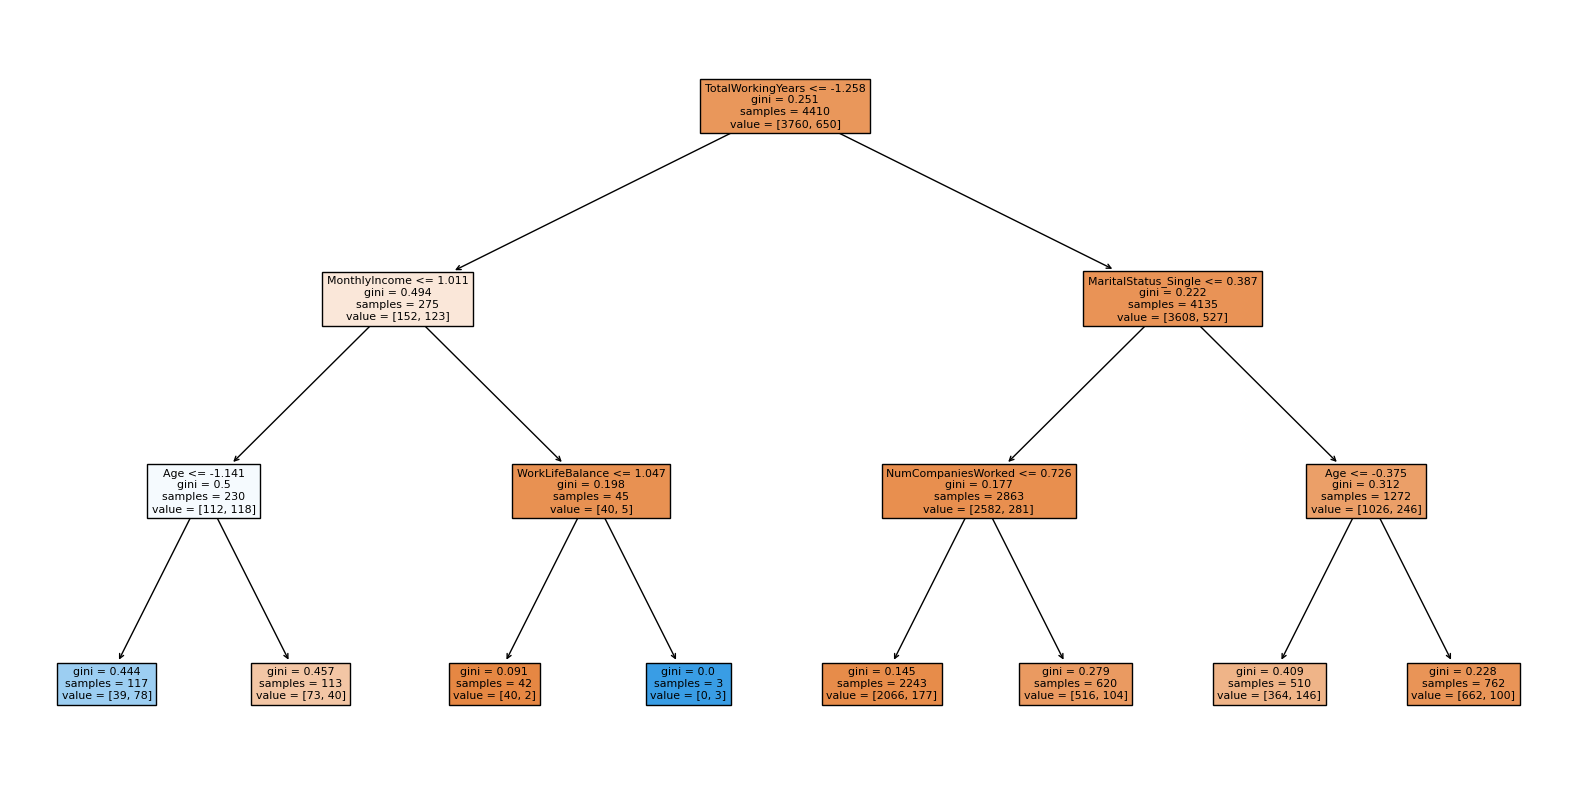

In [5]:
# Crear y entrenar el modelo de árbol de decisión
rtree = DecisionTreeClassifier(max_depth=3)
rtree.fit(X=X, y=y)

# Generar una representación de texto del árbol de decisión
tree_text = export_text(rtree, feature_names=X.columns.tolist())
print(tree_text)

# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(rtree, feature_names=X.columns.tolist(), filled=True)
plt.show()

## Modelos candidatos

In [6]:
# Define los modelos seleccionados
m_logreg = LogisticRegression()
m_tree = DecisionTreeClassifier()
m_rf = RandomForestClassifier()
m_gbt = GradientBoostingClassifier()

# Lista de modelos seleccionados
modelos=list([m_logreg,m_tree, m_rf, m_gbt])

## Selección de variables

In [7]:
# Ahora, utiliza estos modelos para seleccionar las variables
var_names = funciones.sel_variables(modelos, X, y, threshold="2*mean")
X2=X[var_names] ### matriz con variables sele ccionadas
X2.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               4410 non-null   float64
 1   BusinessTravel_Travel_Frequently  4410 non-null   float64
 2   DistanceFromHome                  4410 non-null   float64
 3   EnvironmentSatisfaction           4410 non-null   float64
 4   JobSatisfaction                   4410 non-null   float64
 5   MaritalStatus_Single              4410 non-null   float64
 6   MonthlyIncome                     4410 non-null   float64
 7   NumCompaniesWorked                4410 non-null   float64
 8   PercentSalaryHike                 4410 non-null   float64
 9   TotalWorkingYears                 4410 non-null   float64
 10  YearsAtCompany                    4410 non-null   float64
 11  YearsSinceLastPromotion           4410 non-null   float64
 12  YearsW

Para la seleccion de variables utilizamos SelectFromModel y obtuvimos las variables anteriores, pasando de 43 variables explicativas a 10.



## Definir modelo ganador

In [8]:
# Calcular AUC-ROC para todos los modelos con todas las variables
f1score_df = funciones.medir_modelos(modelos, "f1", X, y, 30)
# Calcular AUC-ROC para todos los modelos con variables seleccionadas
f1_score_varsel = funciones.medir_modelos(modelos, "f1", X2, y, 30)

In [9]:
f1=pd.concat([f1score_df,f1_score_varsel],axis=1)
f1.columns=['rl', 'dt', 'rf', 'gb', 'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
f1

,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.370370,0.975610,0.975610,0.625000,0.250000,0.975610,0.975610,0.482759
1,0.320000,1.000000,1.000000,0.580645,0.320000,1.000000,1.000000,0.562500
2,0.230769,0.975610,1.000000,0.482759,0.086957,0.975610,0.975610,0.413793
3,0.230769,1.000000,1.000000,0.645161,0.250000,1.000000,1.000000,0.500000
4,0.086957,1.000000,1.000000,0.173913,0.090909,1.000000,1.000000,0.444444
5,0.074074,1.000000,1.000000,0.600000,0.240000,1.000000,1.000000,0.482759
6,0.320000,1.000000,1.000000,0.687500,0.320000,1.000000,1.000000,0.727273
7,0.240000,1.000000,1.000000,0.600000,0.173913,1.000000,1.000000,0.384615
8,0.214286,0.551724,0.645161,0.370370,0.086957,0.551724,0.727273,0.384615
9,0.083333,0.000000,0.320000,0.090909,0.000000,0.000000,0.444444,0.240000


<Axes: >

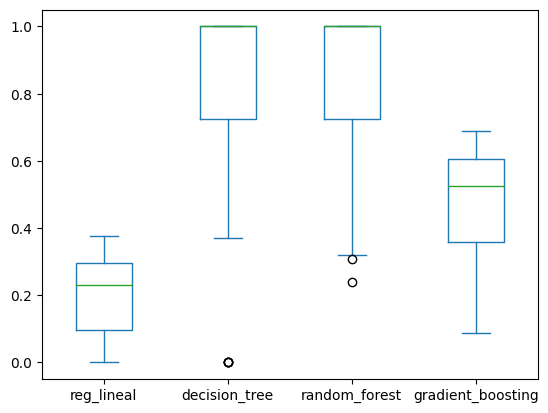

In [10]:
f1score_df.plot(kind='box') #### gráfico para modelos todas las variables

<Axes: >

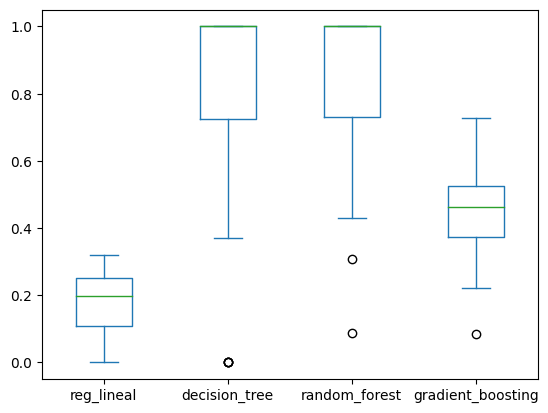

In [11]:
f1_score_varsel.plot(kind='box') ### gráfico para modelo variables seleccionadas

<Axes: >

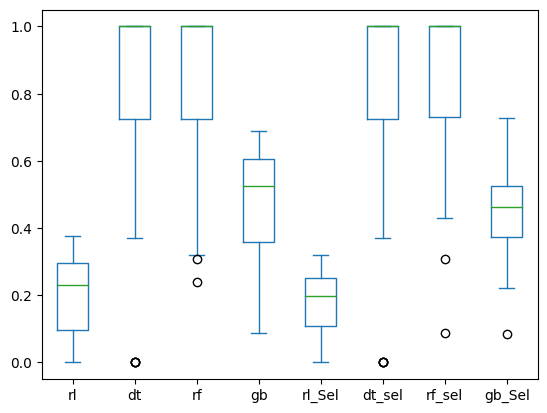

In [12]:
f1.plot(kind='box') ### gráfico para modelos sel y todas las variables

In [13]:
f1.mean()

rl        0.212993
dt        0.790158
rf        0.842176
gb        0.467928
rl_Sel    0.190291
dt_sel    0.790158
rf_sel    0.848142
gb_Sel    0.445383
dtype: float64

Dado que estamos abordando un problema de clasificación con desbalance de clases y considerando los problemas de negocio relacionados con la alta tasa de retiros de empleados, se requiere un modelo que pueda equilibrar la precisión y la exhaustividad en la predicción de los retiros. Los modelos Random Forest y Decision Tree han demostrado ser opciones efectivas en este tipo de problemas, ya que ofrecen un buen equilibrio entre precisión y exhaustividad, como lo demuestran sus altos puntajes de F1 score.

Además, consideramos el modelo con variables seleccionadas debido a su rendimiento comparable al modelo con todas las variables. Esto nos permite reducir la complejidad del modelo y el costo computacional sin comprometer significativamente el desempeño predictivo. Dado que nuestro objetivo es identificar las variables más influyentes en la tasa de retiros y pronosticar con precisión las salidas de los empleados, este enfoque nos proporciona una solución eficiente y efectiva para abordar nuestros problemas de negocio.

Finalmente, entrenaremos el modelo Ramdon Forest con las variables seleccionadas.



## Afinamiento de hiperparámetros

In [14]:
# Grilla de hiperparametros para el modelo Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],  # Criterios para la división de nodos
    'max_depth': [5, 10, 15],     # Profundidad máxima del árbol
    'min_samples_split': [5, 20, 100 ],    # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],      # Número mínimo de muestras requeridas en un nodo hoja
    'max_features': [5, 20],  # Número máximo de características a considerar en cada división
    'class_weight': [None, 'balanced']  # Peso de las clases para abordar el desbalance de clases
}

In [15]:
# Grilla de hiperparametros para el modelo Ramdon Forest
param_grid_rf = {
    'n_estimators': [5, 50, 100, 200, 500],  # Número de árboles en el bosque
    'max_features': [5, 20],  # Número de características a considerar en cada división
    'max_depth': [10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [5, 20, 100],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas para estar en un nodo hoja
    'bootstrap': [True, False]  # Método de muestreo para construir árboles
}

In [16]:
# Crear la instancia de GridSearchCV para búsqueda de hiperparámetros
tun_dt = GridSearchCV(m_tree, param_grid=param_grid_dt, scoring='f1', cv=5)
# Realizar la búsqueda de hiperparámetros en los datos
tun_dt.fit(X2, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15], 'max_features': [5, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 20, 100]},
             scoring='f1')

In [17]:
pd.set_option('display.max_colwidth', 100)
resultados=tun_dt.cv_results_
tun_dt.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
153,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 20, 'min_samp...",0.911365
156,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 20, 'min_samp...",0.908584
147,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 5, 'min_sampl...",0.882621
144,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 5, 'min_sampl...",0.880028
210,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'max_features': 20, 'min_s...",0.875069
...,...,...
58,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'min_samples_l...",0.273707
54,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'min_samples_l...",0.268341
62,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'min_samples_l...",0.266850
60,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'min_samples_l...",0.262242


In [18]:
# Técnica de búsqueda de hiperparámetros
tun_rf = RandomizedSearchCV(m_rf,param_distributions=param_grid_rf,n_iter=6,scoring="f1")
tun_rf.fit(X2,y)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=6,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': [5, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [5, 20, 100],
                                        'n_estimators': [5, 50, 100, 200, 500]},
                   scoring='f1')

In [19]:
pd.set_option('display.max_colwidth', 100)
resultados=tun_rf.cv_results_
tun_rf.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
3,"{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 5, 'max_dep...",0.740975
0,"{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 5, 'max_dep...",0.719116
5,"{'n_estimators': 5, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 5, 'max_dept...",0.621238
4,"{'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 5, 'max_dep...",0.590193
1,"{'n_estimators': 5, 'min_samples_split': 100, 'min_samples_leaf': 4, 'max_features': 20, 'max_de...",0.375258
2,"{'n_estimators': 500, 'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 5, 'max_d...",0.204946


In [20]:
# Mejor grilla del modelo Decision Tree
dt_final = tun_dt.best_estimator_

In [21]:
# Guardar el modelo con hyperparameter tunning
rf_final = tun_rf.best_estimator_

## Analisis del los modelos Decision Tree y Ramdon Forest

In [22]:
#####Evaluar métrica de entrenamiento y evaluación para mirar sobre ajuste ####
eval_dt=cross_validate(dt_final,X2,y,cv=30,scoring="f1",return_train_score=True)
eval_rf=cross_validate(rf_final,X2,y,cv=30,scoring="f1",return_train_score=True)

In [23]:
#### convertir resultado de evaluacion entrenamiento y evaluacion en data frame para Desicion Tree
train_dt=pd.DataFrame(eval_dt['train_score'])
test_dt=pd.DataFrame(eval_dt['test_score'])
train_test_dt=pd.concat([train_dt, test_dt],axis=1)
train_test_dt.columns=['train_score','test_score']
train_test_dt

,train_score,test_score
0,0.893466,0.851064
1,0.899135,0.930233
2,0.919355,0.888889
3,0.925461,0.976744
4,0.906994,0.893617
5,0.910675,0.875000
6,0.910275,0.913043
7,0.891258,0.875000
8,0.906318,0.913043
9,0.934621,0.930233


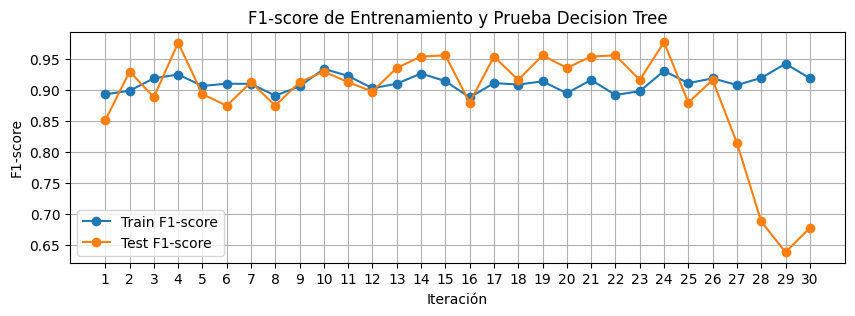

In [24]:
# Número de iteraciones
iterations = range(1, len(train_test_dt) + 1)

# Crear el gráfico de líneas
plt.figure(figsize=(10, 3))
plt.plot(iterations, train_test_dt['train_score'], marker='o', label='Train F1-score')
plt.plot(iterations, train_test_dt['test_score'], marker='o', label='Test F1-score')
plt.title('F1-score de Entrenamiento y Prueba Decision Tree')
plt.xlabel('Iteración')
plt.ylabel('F1-score')
plt.xticks(iterations)
plt.legend()
plt.grid(True)
plt.show()

In [25]:
train_test_dt["test_score"].mean()

0.8922702498743307

En los datos parece que el desempeño en entrenamiento es generalmente más alto que en los datos de evaluación, pero no es significativamente mayor. Sin embargo, hay algunas instancias en las que el desempeño en los datos de entrenamiento es considerablemente más alto que en los datos de evaluación. Esto sugiere que puede haber cierto grado de sobreajuste en el modelo, pero no es muy pronunciado.


In [26]:
#### convertir resultado de evaluacion entrenamiento y evaluacion en data frame para Ramdon Forest
train_rf=pd.DataFrame(eval_rf['train_score'])
test_rf=pd.DataFrame(eval_rf['test_score'])
train_test_rf=pd.concat([train_rf, test_rf],axis=1)
train_test_rf.columns=['train_score','test_score']
train_test_rf

,train_score,test_score
0,0.910596,0.864865
1,0.910908,0.950000
2,0.905597,0.864865
3,0.905316,0.764706
4,0.901173,0.864865
5,0.906511,0.864865
6,0.901598,0.923077
7,0.906822,0.833333
8,0.910160,0.500000
9,0.923588,0.173913


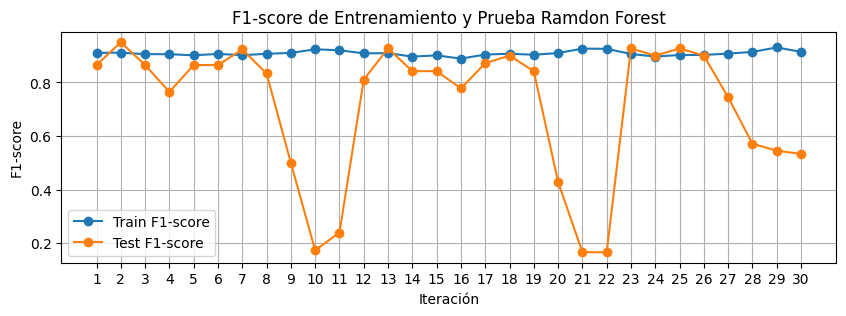

In [27]:
# Número de iteraciones
iterations = range(1, len(train_test_rf) + 1)

# Crear el gráfico de líneas
plt.figure(figsize=(10, 3))
plt.plot(iterations, train_test_rf['train_score'], marker='o', label='Train F1-score')
plt.plot(iterations, train_test_rf['test_score'], marker='o', label='Test F1-score')
plt.title('F1-score de Entrenamiento y Prueba Ramdon Forest')
plt.xlabel('Iteración')
plt.ylabel('F1-score')
plt.xticks(iterations)
plt.legend()
plt.grid(True)
plt.show()

In [28]:
train_test_rf["test_score"].mean()

0.7155994318356318

En conclusión se elige el modelo Decision Tree por que tiene menor sobre ajuste y mayor desempeño que el modelo Ramdon Forest

## Matriz de confusión

In [29]:
# separar datos de train y test
x_train,x_test,y_train,y_test = train_test_split(X2,y,shuffle = True,test_size=0.30, random_state=123)

In [30]:
y_pred_train_dt = dt_final.predict(x_train) # guardar la predicción para train
y_pred_test_dt = dt_final.predict(x_test) # guardar la predicción para test

[[1101   46]
 [   1  175]]


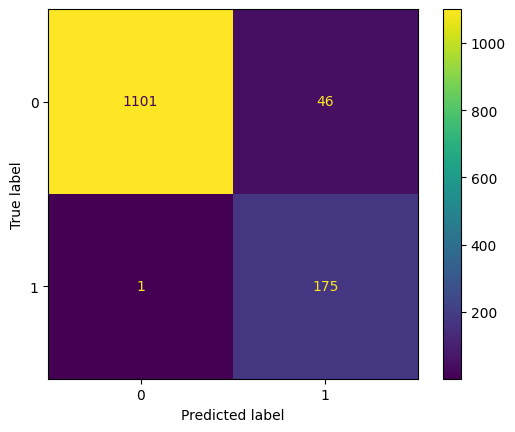

In [31]:
# Matriz de confusión:
cm = confusion_matrix(y_test, y_pred_test_dt, labels=dt_final.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_final.classes_)
disp.plot();
print(cm)


Basandonos en la matriz de confusión, se pueden extraer algunas conclusiones:

Verdaderos positivos y Verdaderos negativos:
Hay 1101 predicciones correctas de la clase negativa (no renunciar).
También hay 175 predicciones correctas de la clase positiva (renunciar).

Falsos positivos y Falsos negativos:
Hay 46 falsas alarmas (falsos positivos), es decir, casos donde el modelo predijo incorrectamente que un empleado renunciaría cuando en realidad no lo hizo.
Solo hay 1 caso donde el modelo predijo incorrectamente que un empleado no renunciaría cuando sí lo hizo (falso negativo).

Precisión y exhaustividad:
* La precisión es alta, ya que el número de verdaderos positivos es alto en comparación con los falsos positivos.
* La exhaustividad también parece ser alta, ya que el número de verdaderos positivos es alto en comparación con los falsos negativos.

Dado que el objetivo es minimizar los costos asociados con la alta rotación de personal, puede ser más crítico evitar los falsos positivos, ya que estos pueden resultar en una mayor inversión en empleados que eventualmente dejarán la empresa. Sin embargo, también es importante equilibrar esto con la necesidad de retener el talento y evitar la pérdida de empleados valiosos, lo que resalta la importancia de un enfoque integral en la gestión de recursos humanos y la toma de decisiones estratégicas.

In [32]:
TP=cm[0,0]
FP=cm[1,0]
FN=cm[0,1]
TN=cm[1,1]

print(f"Accuracy test: {accuracy_score(y_test, y_pred_test_dt)}")
print(f'Precicion: {TP/(TP+FP)}')
print(f'Recuperacion (Sensibilidad)): {TP/(TP+FN)}')
print(f'F1-score:', f1_score(y_test, y_pred_test_dt, average='binary'))
print(f'Especificidad: {TN/(FP+TN)}')

Accuracy test: 0.9644746787603931
Precicion: 0.9990925589836661
Recuperacion (Sensibilidad)): 0.959895379250218
F1-score: 0.8816120906801007
Especificidad: 0.9943181818181818


* La Accuracy del modelo en el conjunto de prueba es del 96.45%. Esto indica la proporción de predicciones correctas (tanto verdaderos positivos como verdaderos negativos) sobre el total de predicciones realizadas.

* La precisión es del 99.91%. Esto significa que la proporción de verdaderos positivos (casos correctamente identificados como positivos) entre todas las observaciones clasificadas como positivas por el modelo es extremadamente alta. Es decir, de todas las predicciones de renuncias hechas por el modelo, la gran mayoría son correctas.

* La recuperación (sensibilidad) es del 95.99%. Esto indica la proporción de casos positivos reales que fueron identificados correctamente por el modelo. Una alta sensibilidad sugiere que el modelo es efectivo para capturar la mayoría de los casos positivos reales.

* El puntaje F1 es del 88.16%. El puntaje F1 es una medida de la precisión del modelo que tiene en cuenta tanto la precisión como la recuperación. Es útil cuando hay un desequilibrio en las clases objetivo, como en este caso de clasificación binaria. Un puntaje F1 alto indica un buen equilibrio entre precisión y recuperación.

* La especificidad es del 99.43%. Esto indica la proporción de casos negativos reales que fueron identificados correctamente por el modelo. Una alta especificidad sugiere que el modelo es efectivo para evitar falsas alarmas en la predicción de casos negativos.

En resumen, el modelo tiene un buen desempeño en la clasificación, con altos valores de precisión, sensibilidad, F1-score y especificidad.

In [37]:
X2

,Age,BusinessTravel_Travel_Frequently,DistanceFromHome,EnvironmentSatisfaction,JobSatisfaction,MaritalStatus_Single,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,1.541369,-0.481859,-0.393938,0.252200,1.148864,-0.685565,1.405136,-0.676179,-1.150554,-1.322079,-0.981014,-0.679146,-1.155935
1,-0.648668,2.075297,0.099639,0.252200,-0.666107,1.458650,-0.491661,-1.076870,2.129306,-0.678877,-0.327893,-0.368715,-0.034520
2,-0.539166,2.075297,0.963398,-0.665460,-0.666107,-0.685565,2.725053,-0.676179,-0.057267,-0.807517,-0.327893,-0.679146,-0.314873
3,0.117845,-0.481859,-0.887515,1.169861,1.148864,-0.685565,0.386301,0.125205,-1.150554,0.221606,0.161947,1.493867,0.245834
4,-0.539166,-0.481859,0.099639,1.169861,-1.573592,1.458650,-0.884109,0.525897,-0.877232,-0.292956,-0.164613,-0.679146,-0.034520
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.555852,-0.481859,-0.517332,1.169861,-1.573592,1.458650,-0.100700,0.125205,0.489376,-0.164315,-0.654454,-0.679146,-0.595227
4406,-0.867672,-0.481859,-0.887515,1.169861,1.148864,-0.685565,-0.812504,-0.275487,-0.057267,-0.164315,-0.654454,-0.679146,-0.595227
4407,-1.305679,-0.481859,1.950552,-1.583120,0.241379,-0.685565,-0.595138,-1.076870,1.309341,-0.807517,-0.491174,-0.368715,-0.595227
4408,0.555852,-0.481859,1.086793,1.169861,-1.573592,-0.685565,-0.872210,-1.076870,-0.330589,-0.164315,0.325228,1.493867,1.086895


In [40]:
##### Mirar importancia de variables para tomar acciones ###
pd.set_option('display.max_rows', 100)
importancia1=pd.DataFrame(dt_final.feature_names_in_)
importancia2=pd.DataFrame(dt_final.feature_importances_)
importancia=pd.concat([importancia1,importancia2],axis=1)
importancia.columns=["variable","peso"]
importancia.sort_values('peso')

importancia.sort_values(by=["peso"], ascending=False)
importancia.to_excel("/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/variables_importances.xlsx")
dt_final.predict(X2[X2.index==0])

array([0])

In [33]:
### función para exportar y guardar objetos de python (cualqueira)
joblib.dump(rf_final, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/rf_final.pkl") ## modelo ramdon forest
joblib.dump(dt_final, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/dt_final.pkl") ## modelo decision Tree
joblib.dump(var_names, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/scaler.pkl") ##

['/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/scaler.pkl']